In [50]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")

dpi = 800


In [51]:
results_dir = "/clusterfs/ml4hep/rrmastandrea/NF_results/"

n_sig_inj = [0, 300, 500, 750, 1000, 1200, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]# 10000]
seeds = [x for x in range(17)]



# Load in


In [56]:
def get_sic_rejection(idd, seed, n):
    
    loc_dir = f"{results_dir}/nsig_inj{n}_seed1/"
    
    path_to_fpr = f"{loc_dir}/fpr_{idd}_{seed}.npy"
    path_to_tpr = f"{loc_dir}/tpr_{idd}_{seed}.npy"
   
    fpr = np.load(path_to_fpr)
    tpr = np.load(path_to_tpr)
    
    # get the nonzero entries of fpr
    fpr_nonzero_indices = np.where(fpr != 0)
    fpr_nonzero = fpr[fpr_nonzero_indices]
    tpr_nonzero = tpr[fpr_nonzero_indices]

    rejection = 1.0 / fpr_nonzero #np.divide(1.0, fpr, out=np.zeros_like(fpr), where=fpr!=0)
    sic = tpr_nonzero / np.sqrt(fpr_nonzero) #np.divide(tpr, np.sqrt(fpr), out=np.zeros_like(tpr), where=np.sqrt(fpr)!=0)
    
    
    return tpr_nonzero, sic, rejection


x_axis = np.logspace(-8, 0, 400)


keys = ["full_sup", "feta", "cathode", "curtains", "salad", "combined"]


rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
                 

sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}

max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}


for n in n_sig_inj:
    
    for seed in seeds:
        
        for k in keys:
            
            if k == "full_sup":
                tpr, sic, rejection = get_sic_rejection(k, seed, 0)
            else: 
                tpr, sic, rejection = get_sic_rejection(k, seed, n)
                
            
            interp_sic = np.interp(x_axis, tpr, sic)
            interp_rej = np.interp(x_axis, tpr, rejection)
            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            max_sics_dict[k][n].append(np.nanmax(sic[np.isfinite(sic)]))
            

# Take the avg

In [57]:
def get_mean_std(loc_list):
    
    mean = np.nanmedian(loc_list, axis = 0)
    std = np.nanstd(loc_list, axis = 0)
    
    return mean, std

mean_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
mean_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
mean_max_sics_dict = {k:[[],[]] for k in keys} # mean, stf
    
   

for n in n_sig_inj:
    
    for k in keys:
        
        mean_rejections_dict[k][n] = get_mean_std(rejections_dict[k][n])
        mean_sics_dict[k][n] = get_mean_std(sics_dict[k][n])
        mean_max_sics_dict[k][0].append(np.median(max_sics_dict[k][n]))
        mean_max_sics_dict[k][1].append(np.std(max_sics_dict[k][n]))
        



for k in keys:
    mean_max_sics_dict[k][0] = np.array(mean_max_sics_dict[k][0])
    mean_max_sics_dict[k][1] = np.array(mean_max_sics_dict[k][1])
    


In [58]:
n_to_plot = [1200]

colors_dict = {"full_sup":"green",
               "salad": "blue",
               "feta": "purple",
               "cathode":"pink",
               "curtains":"orange",
                "combined": "red"}

labels_dict = {"full_sup":"Full. Sup. ",
               "salad": "SALAD",
               "feta": "FETA",
               "cathode":"CATHODE",
               "curtains":"CURTAINs",
                "combined": "Combined"}


l = 3
f_1 = 20
f_2 = 30

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


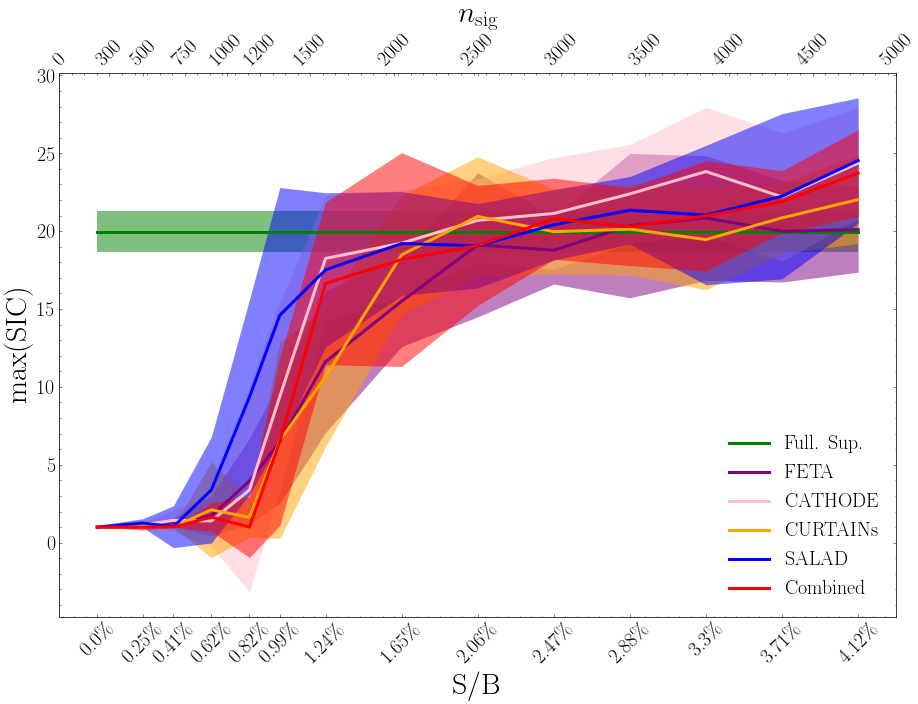

In [59]:
num_bkg = 121339

x_vals = [n / num_bkg for n in n_sig_inj]



fig = plt.figure(figsize = (15, 10)) 
for k in keys:

    plt.plot(x_vals, mean_max_sics_dict[k][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

    plt.fill_between(x_vals, mean_max_sics_dict[k][0] -mean_max_sics_dict[k][1],
                        mean_max_sics_dict[k][0] + mean_max_sics_dict[k][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)
   

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(n_sig_inj)
ax2.set_xticklabels(n_sig_inj, size=f_1, rotation = 45)
ax2.set_xlabel(r"$n_\mathrm{sig}$", fontsize = f_2, labelpad = 10)


ax1.set_xticks(x_vals)
ax1.set_xticklabels([f"{np.round(100*x, 2)}\%" for x in x_vals], size=f_1, rotation = 45)
ax1.set_xlabel("S/B", fontsize = f_2)

ax1.legend(fontsize = f_1, loc = "lower right")

ax1.set_ylabel("max(SIC)", fontsize = f_2)
ax1.tick_params(axis='both', which='major', labelsize=f_1)
fig.savefig(f"paper_plots/maxsic.png", dpi = dpi)

plt.show()





# SIC

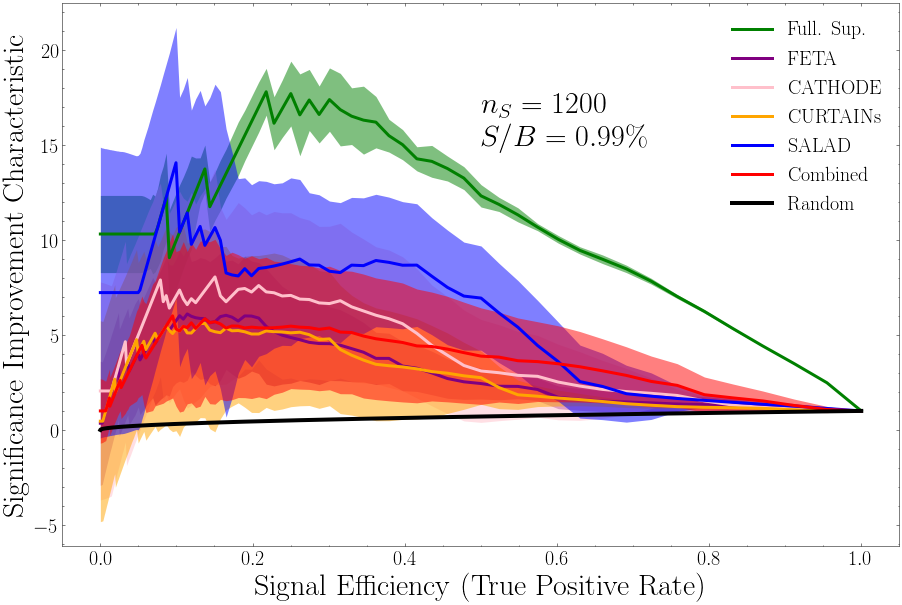

In [60]:


for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10))

    for k in keys:
        plt.plot(x_axis, mean_sics_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

        plt.fill_between(x_axis, mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 15, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)

    plt.legend(fontsize = f_1)
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)    
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    #plt.title(f"Num injected events: {n}")
    
    fig.savefig(f"paper_plots/sic_{n}.png", dpi = dpi)
    
    plt.show()

# Rejection

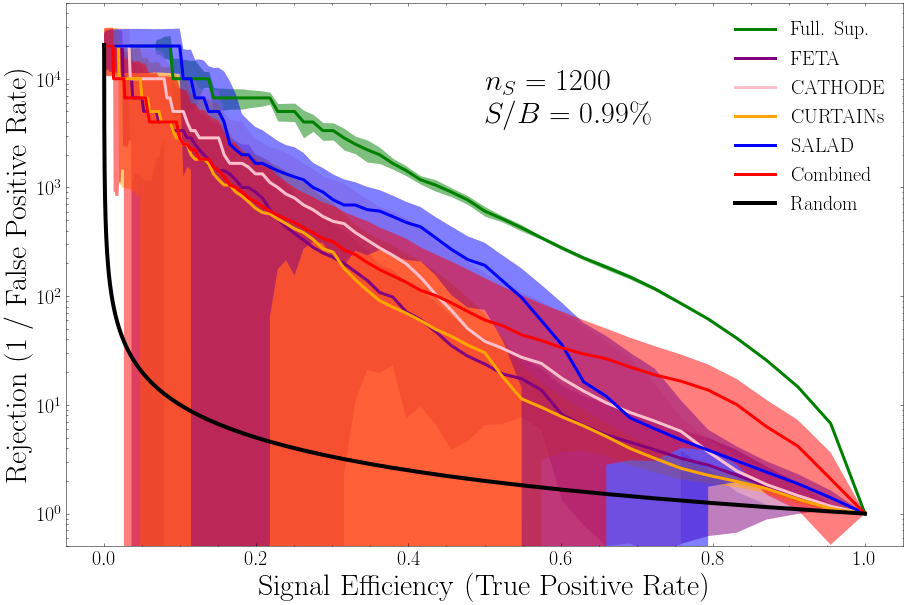

In [61]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        plt.plot(x_axis, mean_rejections_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

        plt.fill_between(x_axis, mean_rejections_dict[k][n][0] - mean_rejections_dict[k][n][1],
                         mean_rejections_dict[k][n][0] + mean_rejections_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)

    plt.plot(x_axis[184:], 1.0/x_axis[184:], label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 4000, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)

    plt.legend(fontsize = f_1)  
    plt.ylim(5e-1, 5e4)
    plt.yscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)  
    plt.ylabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"paper_plots/rej_{n}.png", dpi = dpi)

    plt.show()

## SIC vs rej

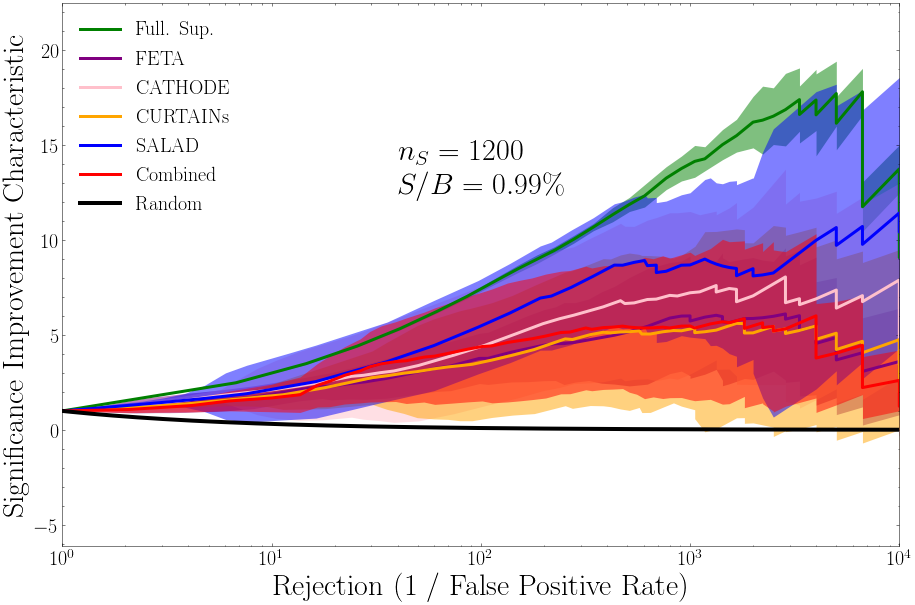

In [62]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        plt.plot(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

        plt.fill_between(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)

    plt.plot(1.0/x_axis[184:], x_axis[184:]/np.sqrt(x_axis[184:]), label = "Random", color = "black", linewidth = l+1)
    
    plt.text(40, 12.5, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)
    plt.legend(fontsize = f_1)
    plt.xscale("log")
    plt.xlabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    fig.savefig(f"paper_plots/sic_vs_rej_{n}.png", dpi = dpi)
    


    plt.show()

(array([0, 1, 2, 4, 6]),)


[1 4 6 5 8]
